<a href="https://colab.research.google.com/github/PierreFontaine/TNS/blob/master/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 2

## Introduction



Dans ce TP nous allons nous pencher sur l'utilisation du DTMF (Dual Tone Multi Frequency). Ce principe est utilisé dans les communications téléphoniques afin de repérer l'appuie des touches sur le clavier.


# Question 1

Premièrement nous allons télécharger le fichier `dtmf1.mat` qui contient un signal échantilloné à 8000Hz. Notre but sera de découvrir quel numéro à été tapé au clavier.

In [0]:
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://github.com/PierreFontaine/TNS/raw/master/dtmf1.mat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   135  100   135    0     0    447      0 --:--:-- --:--:-- --:--:--   448
100  105k  100  105k    0     0   200k      0 --:--:-- --:--:-- --:--:-- 9419k


In [0]:
from scipy.io import loadmat

In [0]:
import numpy as np 
import scipy as sp
from scipy.fftpack import *
import matplotlib.pyplot as plt
from scipy.signal import *
import math

In [0]:
mat_f = loadmat("/content/dtmf1.mat")

In [0]:
print(mat_f.keys())

dict_keys(['__header__', '__version__', '__globals__', 'x'])


In [0]:
print(mat_f['x'][0])

[ 0.          0.          0.         ... -0.19335938  0.10253906
 -0.11767578]


In [0]:
signal = mat_f['x'][0]

In [0]:
print(len(signal))
len(signal)/8000

48046


6.00575

In [0]:
L_s = len(signal)
Fe_s = 8000
Te_s = 1 / Fe_s
t_s = np.arange(0,L_s,1) * Te_s

f_s = (Fe_s/L_s) * np.arange(-L_s/2,L_s/2,1)

Ci dessous nous traçons le signal. Nous pouvons nous apercevoir que différents patterns sont présent.

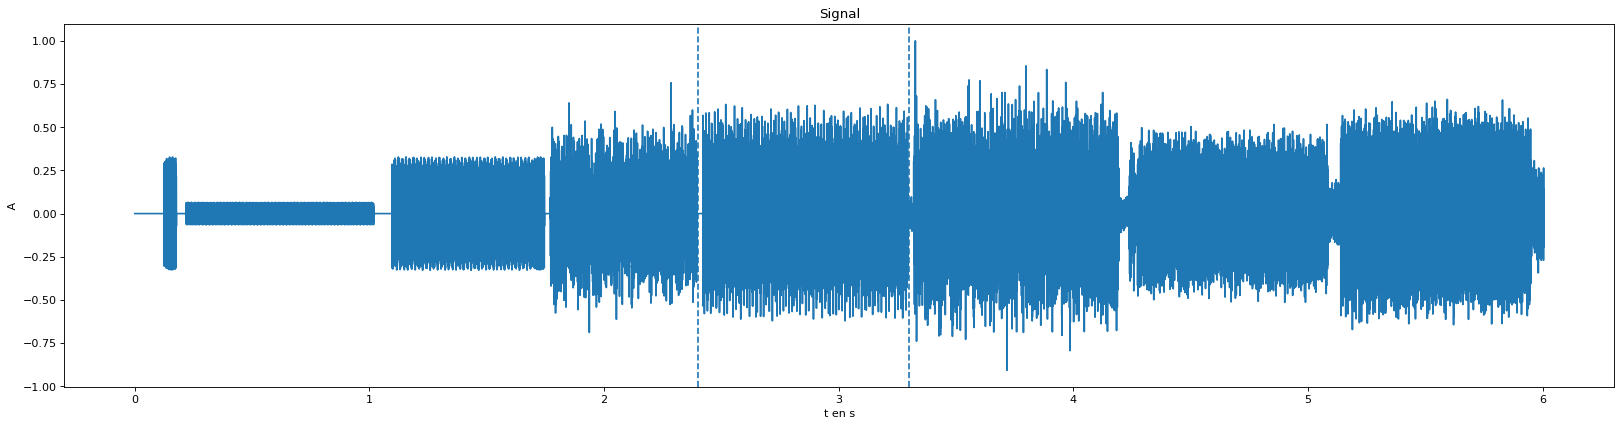

In [0]:
plt.figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t_s, signal)
plt.title("Signal")
plt.xlabel("t en s")
plt.ylabel(" A ")
plt.axvline(2.4, linestyle='--')
plt.axvline(3.3, linestyle='--')
plt.show()

In [0]:
fft_signal = fftshift(abs(fft(signal)))

De ce signal nous pouvons en tirer la FFT, cela nous indiquera les fréquences présentes dans le signal. Nous remarquons qu'elles coincident bien avec les fréquences verticales et horizontales utilisées pour la DTMF.

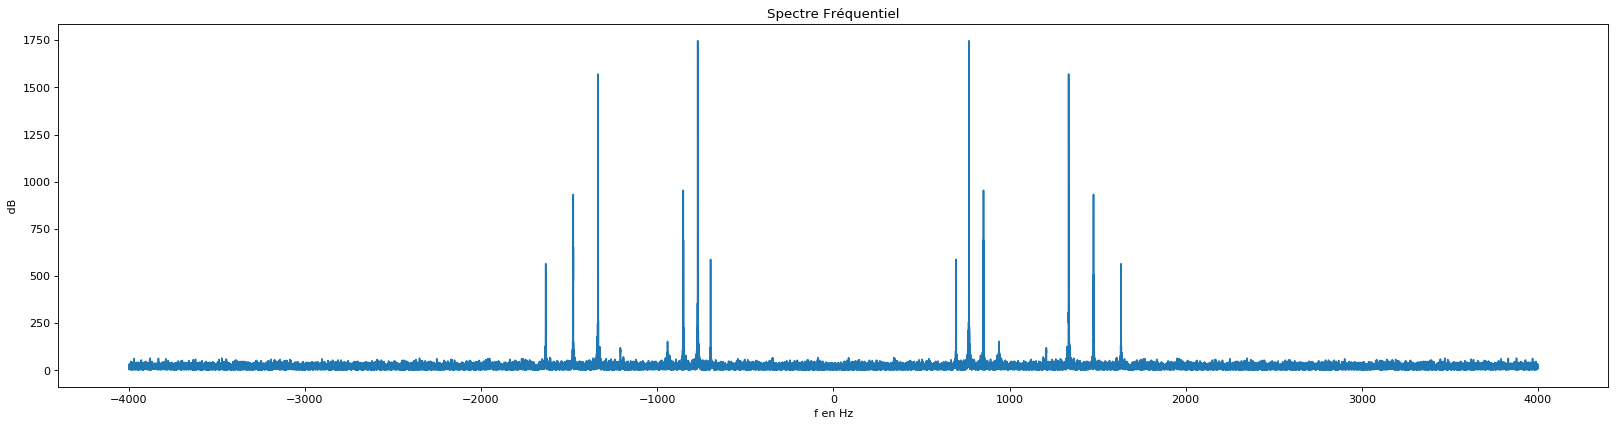

In [0]:
plt.figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(f_s, fft_signal)
plt.title("Spectre Fréquentiel")
plt.xlabel("f en Hz")
plt.ylabel(" dB ")
plt.show()

In [0]:
f, t, Sxx = spectrogram(signal, Fe_s)

Ceci dit, jusqu'ici nous n'avons pas d'information sur la position dans le temps d'une fréquence donnée. 

Ci dessous, nous allons donc tracer le spectrogramme du signal, cela nous donnera en absicce le temps et les fréquences en ordonnée. Ainsi nous serons à meme de retrouver le numéro de téléphone sachant les fréquences activées à l'instant $t$.

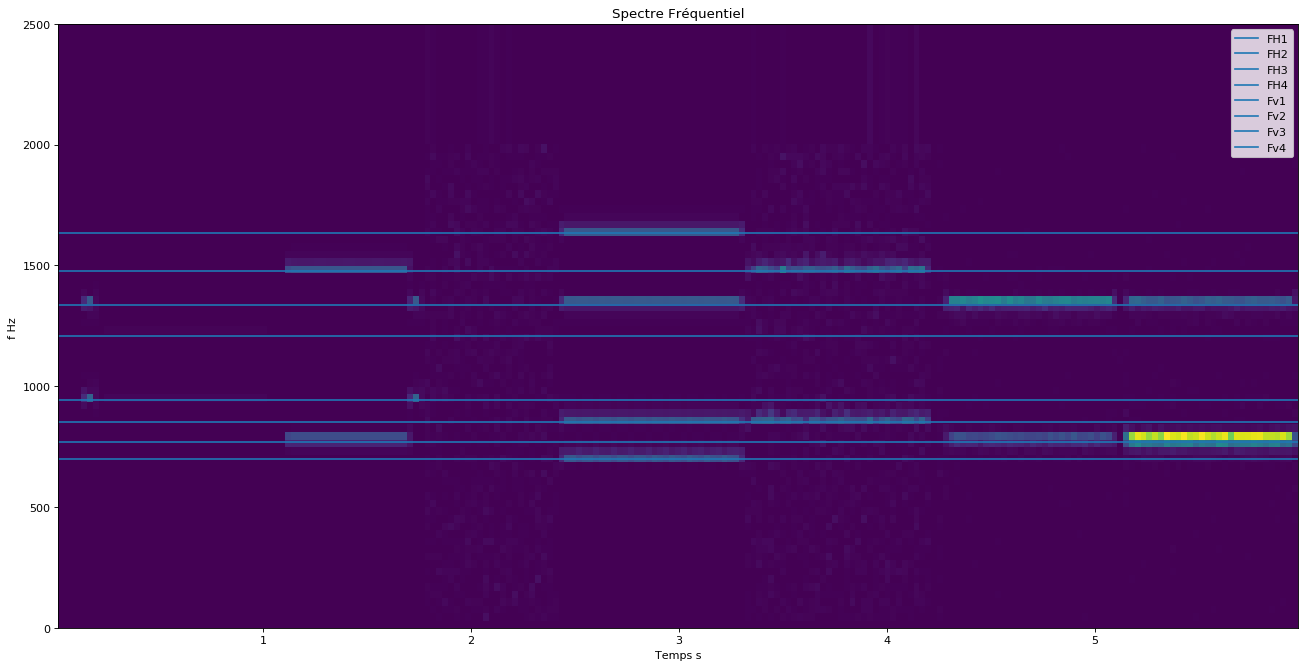

In [0]:
plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.pcolormesh(t, np.fft.fftshift(f), np.fft.fftshift(Sxx, axes=0))
plt.title("Spectre Fréquentiel")
plt.axhline(697, label = "FH1")
plt.axhline(770, label = "FH2")
plt.axhline(852, label = "FH3")
plt.axhline(941, label = "FH4")

plt.axhline(1209, label = "Fv1")
plt.axhline(1336, label = "Fv2")
plt.axhline(1477, label = "Fv3")
plt.axhline(1633, label = "Fv4")
plt.xlabel("Temps s")
plt.ylabel("f Hz ")
plt.ylim(0,2500)
plt.legend()
plt.show()

Nous sommes donc en mesure de retrouver le numéro suivant : 0 60955.

In [0]:
from scipy.io.wavfile import write

write('test.wav', 44100, signal[math.floor(0.5*8000):math.floor(1*8000)])

**FFT de sur un fragment de signal**

Ci dessous nous allons expérimenter d'établir une FFT sur une certaine fenetre de temps. En effet, pour rétablir une relation entre une fréquence jouée et le temps a laquel cette fréquence apparait, nous pouvons faire une fft sur une fenêtre glissante.

In [0]:
signal_portion = signal[math.floor(2.4*8000):math.floor(3.3*8000)]

L_portion = len(signal_portion)
Te_s= 1 / Fe_s
t_portion = np.arange(0,L_portion,1) * Te_s

f_portion = (Fe_s/L_portion) * np.arange(-L_portion/2,L_portion/2,1)

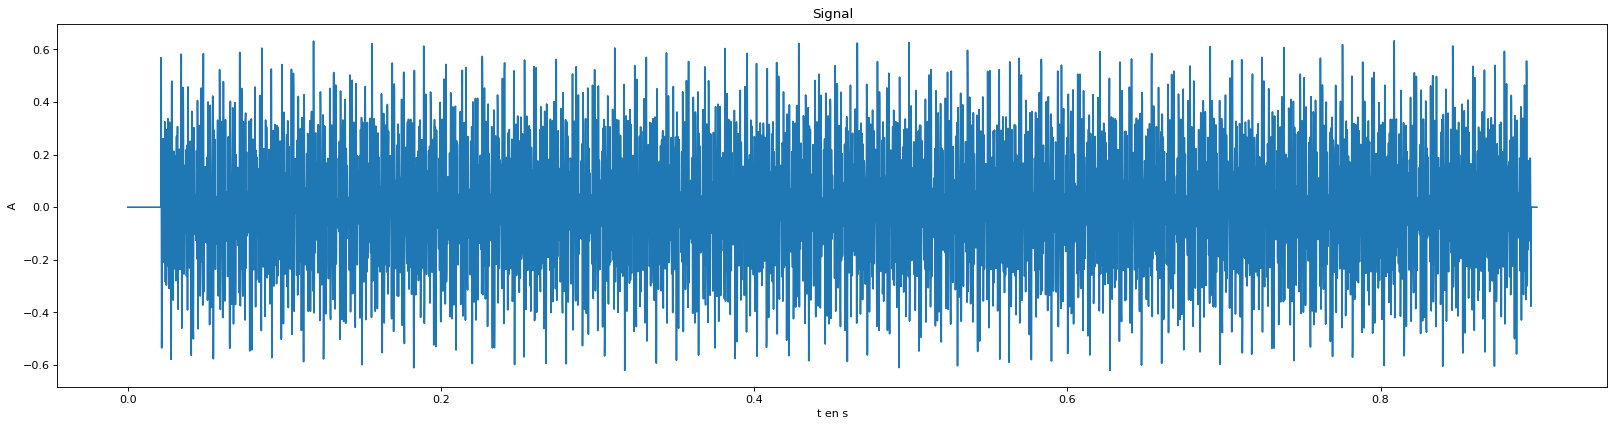

In [0]:
plt.figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t_portion, signal_portion)
plt.title("Signal")
plt.xlabel("t en s")
plt.ylabel(" A ")
plt.show()

In [0]:
fft_signal_portion = fftshift(abs(fft(signal_portion)))

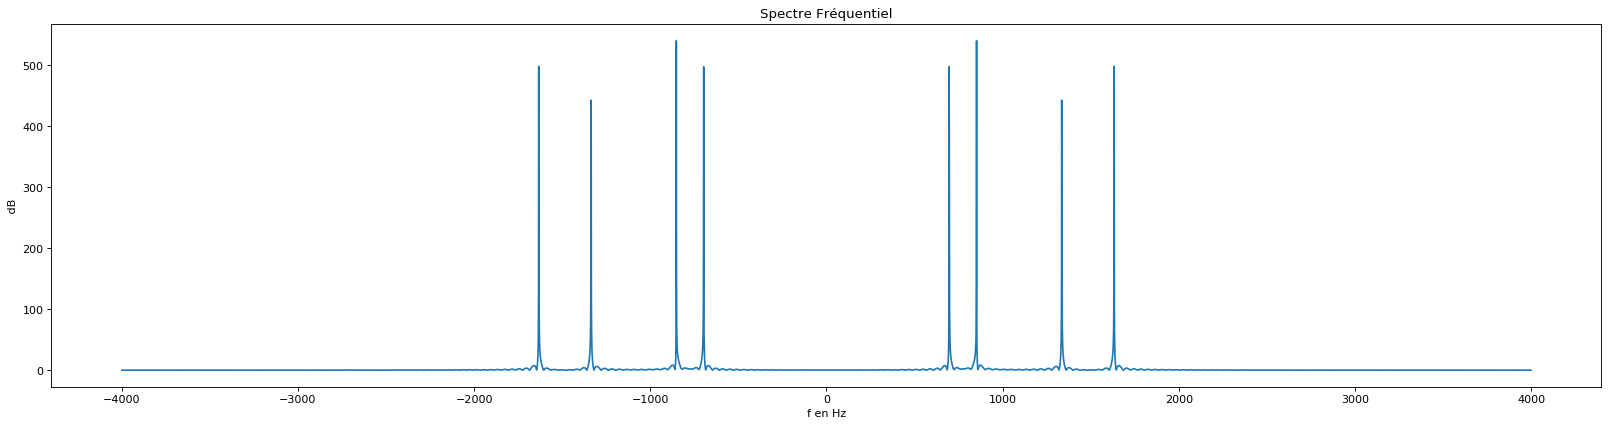

In [0]:
plt.figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(f_portion, fft_signal_portion)
plt.title("Spectre Fréquentiel")
plt.xlabel("f en Hz")
plt.ylabel(" dB ")
plt.show()

Ici nous avons plusieurs pic, car nous sommes en effet sur la partie du signal pour laquel plusieurs fréquences sont activées.

# Question 2

Pour cette question nous allons étudier le code ci dessous. Ce code est une fonction qui prend un vecteur (e.g. dtmf.mat)

```m
function [V, H] = decod_dtmf(x);

Fe = 8000;    % Frequence d'échantillonnage.

% Fréquence du DTMF
Fv = [1209, 1336, 1477, 1633];
Fh = [697, 770, 852, 941];

size = 256; %% Size of the filter.

N = length(x);

for i=1:4
    porteuse_v = exp(2*pi*j*Fv(i)/Fe*(1:N));
    porteuse_v = sign( real(porteuse_v)) + 1i*sign(imag(porteuse_v));
    Demod_V(i,:) = x.*porteuse_v;

    porteuse_h = exp(2*pi*j*Fh(i)/Fe*(1:N));
    porteuse_h = sign( real(porteuse_h)) + 1i*sign(imag(porteuse_h));
    Demod_H(i,:) = x.*porteuse_h;
    
    Filtre_V(i,:)  = conv( Demod_V(i,:), ones(1,size));
    Filtre_H(i,:)  = conv( Demod_H(i,:), ones(1,size));
    
    Filtre_V_decim(i,:) = Filtre_V(i,1:size/2:N);
    Filtre_H_decim(i,:) = Filtre_H(i,1:size/2:N);
end;

V = abs(Filtre_V_decim);
H = abs(Filtre_H_decim);  
subplot(2,1,1);
plot( (1:length(V))/8000*(size/2), V);
legend('fv1', 'fv2', 'fv3', 'fv4');
grid on;
xlabel('t');
ylabel('H')
subplot(2,1,2);
plot( (1:length(H))/8000*(size/2), H);
legend('fh1', 'fh2', 'fh3', 'fh4');
grid on
xlabel('t');
ylabel('H');
```


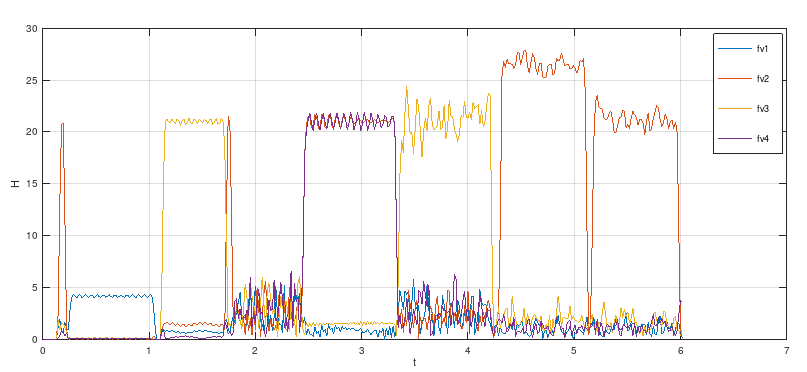

## Explications pas à pas

Dans la suite de ce notebook nous allons décrire comment faire un filtre pour une porteuse à 1209Hz.

### Créer une porteuse à deux canaux

La première étape est de créer une porteuse à 1209Hz. Pour cela nous allons utiliser la forme complexe : 
$$signal = \exp(\frac{2\pi j f_p}{F_s})$$

In [0]:
Fe_p = 1336 # Fréquence de la porteuse
N = 4000 # len(signal)
f_s = (Fe_s/N) * np.arange(-N/2,N/2,1)

porteuse = np.exp((2 * np.pi * 1j * Fe_p / Fe_s * np.arange(0,N,1)))
porteuse = np.sign( np.real(porteuse)) + 1j*np.sign(np.imag(porteuse))

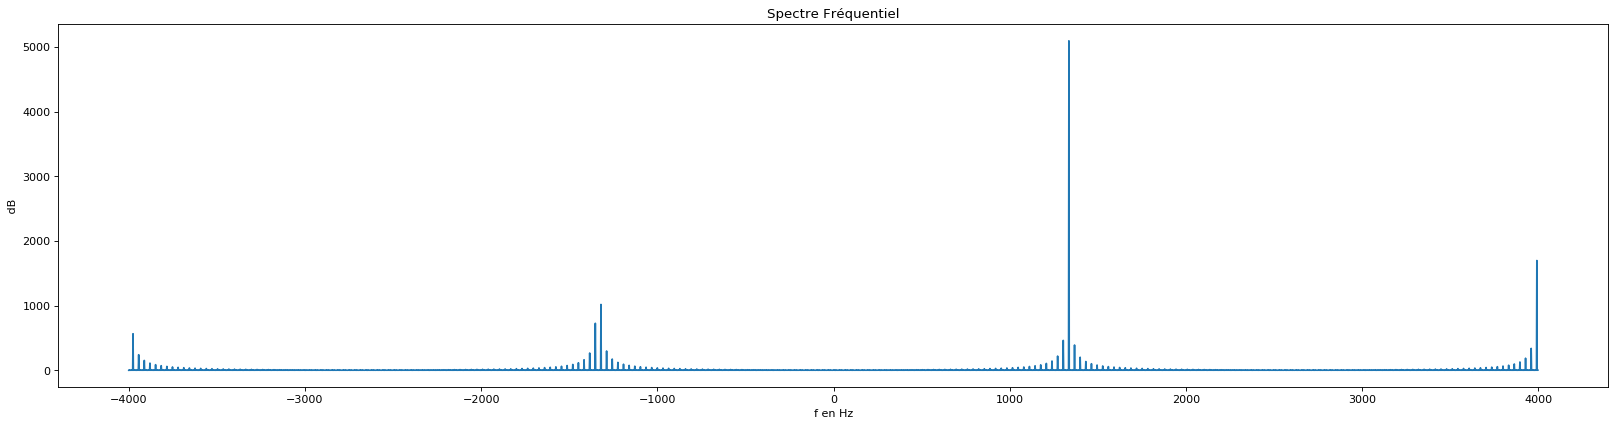

In [0]:
plt.figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(f_s, fftshift(abs(fft(porteuse))))
plt.title("Spectre Fréquentiel")
plt.xlabel("f en Hz")
plt.ylabel(" dB ")
plt.show()

Ci dessus nous observons que notre porteuse est bien à 1336 Hz, nous observons en effet un pic à cet fréquence.

Maintenant nous allons étudier le signal de base entre 4.5 et 5 secondes.

In [0]:
signal_portion = signal[math.floor(4.5*8000):math.floor(5*8000)]

L_portion = len(signal_portion)
Te_s= 1 / Fe_s
t_portion = np.arange(0,L_portion,1) * Te_s

f_portion = (Fe_s/L_portion) * np.arange(-L_portion/2,L_portion/2,1)

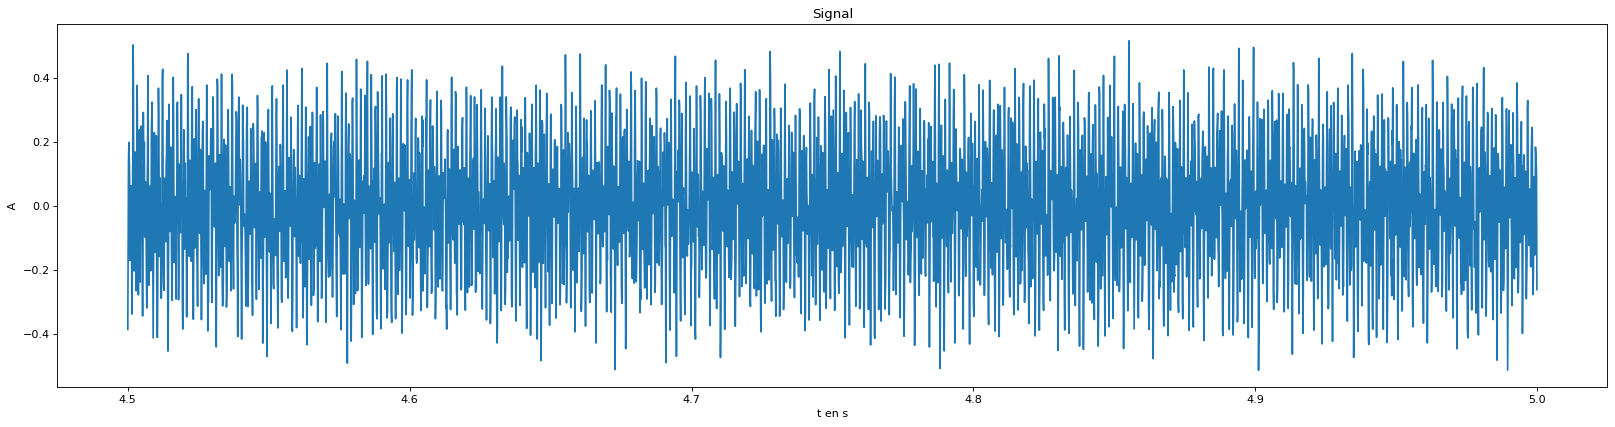

In [0]:
plt.figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t_portion+4.5, signal_portion)
plt.title("Signal")
plt.xlabel("t en s")
plt.ylabel(" A ")
plt.show()

In [0]:
fft_signal_portion = fftshift(abs(fft(signal_portion)))

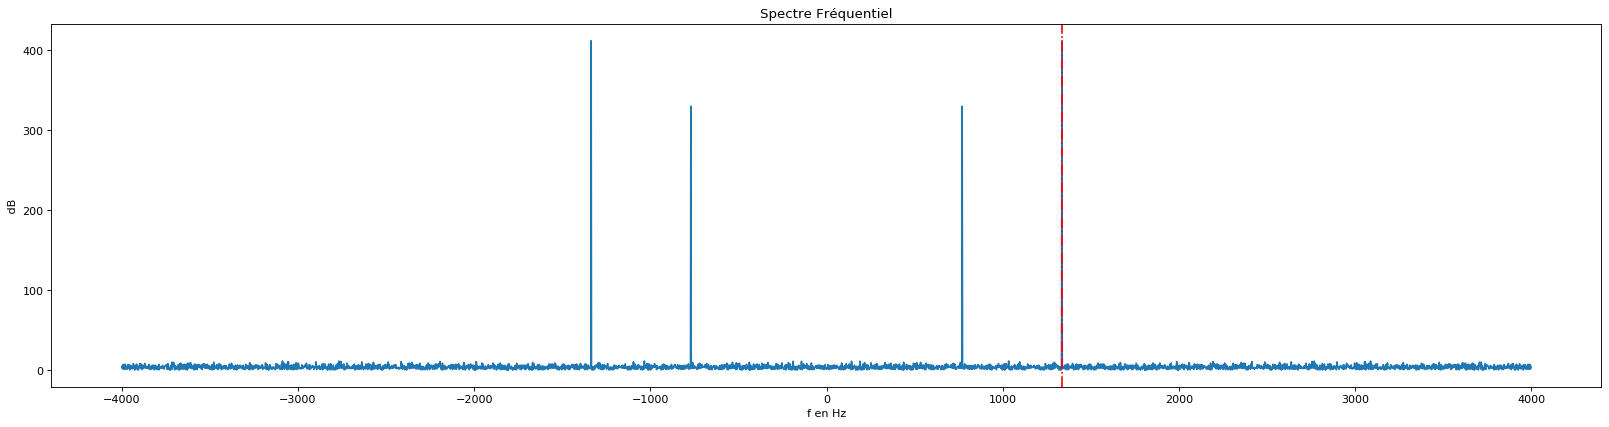

In [0]:
plt.figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(f_portion, fft_signal_portion)
plt.axvline(x=1336, linestyle='-.', color='r')
plt.title("Spectre Fréquentiel")
plt.xlabel("f en Hz")
plt.ylabel(" dB ")
plt.show()

Dans la figure ci dessus, nous avons bien un pic en 1336Hz, nous pouvons observer de façon graphique que le signal vertical rouge en 1336Hz se supperpose avec un pic de la FFT en bleu.

In [0]:
fft_conv = np.convolve(abs(fft(signal_portion)),abs(fft(porteuse)),mode='same')

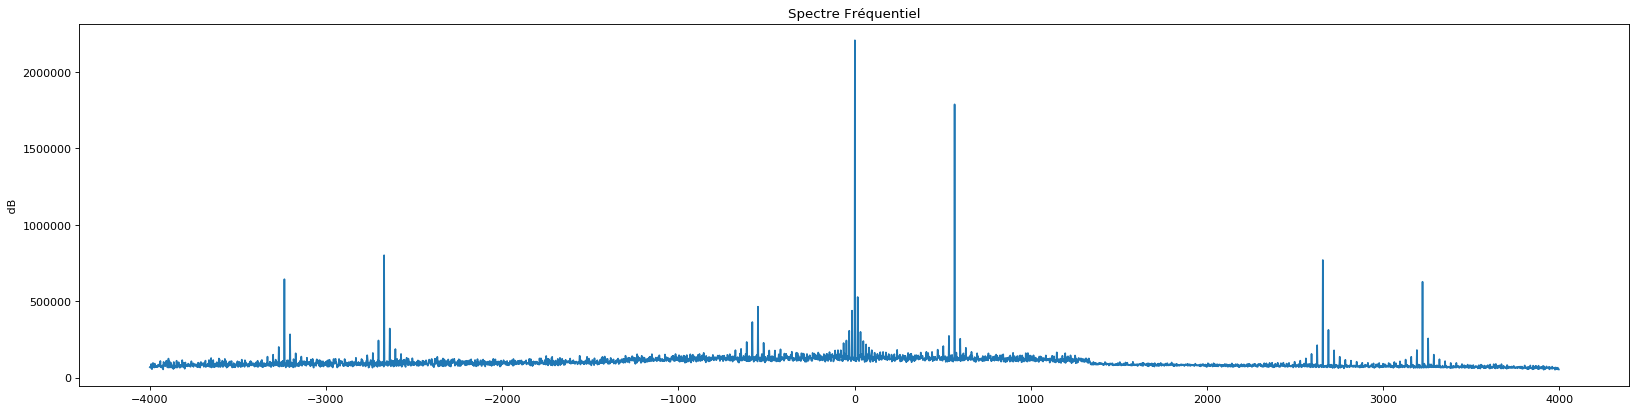

In [0]:
plt.figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(f_portion, fft_conv)
plt.title("Spectre Fréquentiel")
plt.ylabel(" dB ")
plt.show()

Dans la figure ci dessus nous avons convolué le spectre fréquentiel de la porteuse générée à 1336Hz avec le spectre fréquentiel du sigan entre 4.5 et 5 secondes.

Nous observons un pic en 0 de haute energie. En effet, le spectre fréquentiel de notre signal était composé de 4 raies dont 2 aux positions suivantes : 1336Hz et 4000Hz - 1336Hz = 2664Hz.

Lorsque nous appliquons la convolutions entre les deux spectres, nous aurons le spectre fréquentiel du signal qui est décalé de 1336Hz. De ce fait le pique situé en 4000Hz - 1336Hz se retrouve en 4000Hz - 1336Hz + 1336Hz = 4000Hz. Lorsque nous appliquons la symétrie par rapport à l'axe cela va produire un pique de forte énergie en 0.

In [0]:
filtre_passe_bas = fft_conv * abs(fft(256*[1] + 3744*[0]))

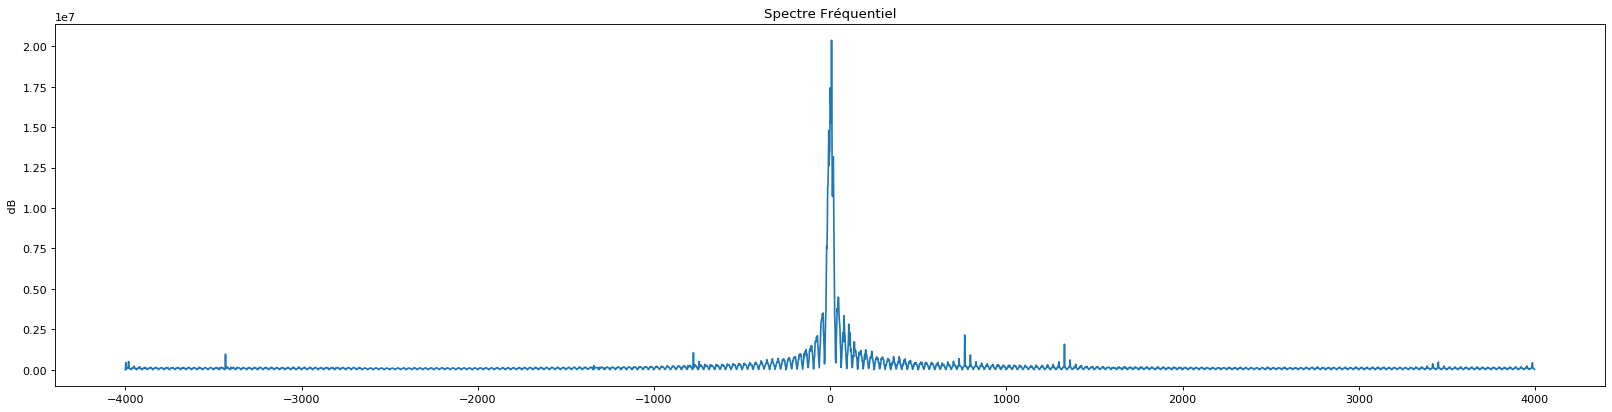

In [0]:
plt.figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(f_portion, fftshift(filtre_passe_bas))
plt.title("Spectre Fréquentiel")
plt.ylabel(" dB ")
plt.show()

Pour ne laisser passer que certaine fréquences, nous appliquons un filtre passe bas qui va donc supprimer toutes les fréquences supérieur à une certaine valeur.

In [0]:
s = np.convolve(signal_portion * porteuse, 256*[1] + 3744*[0], mode='same')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


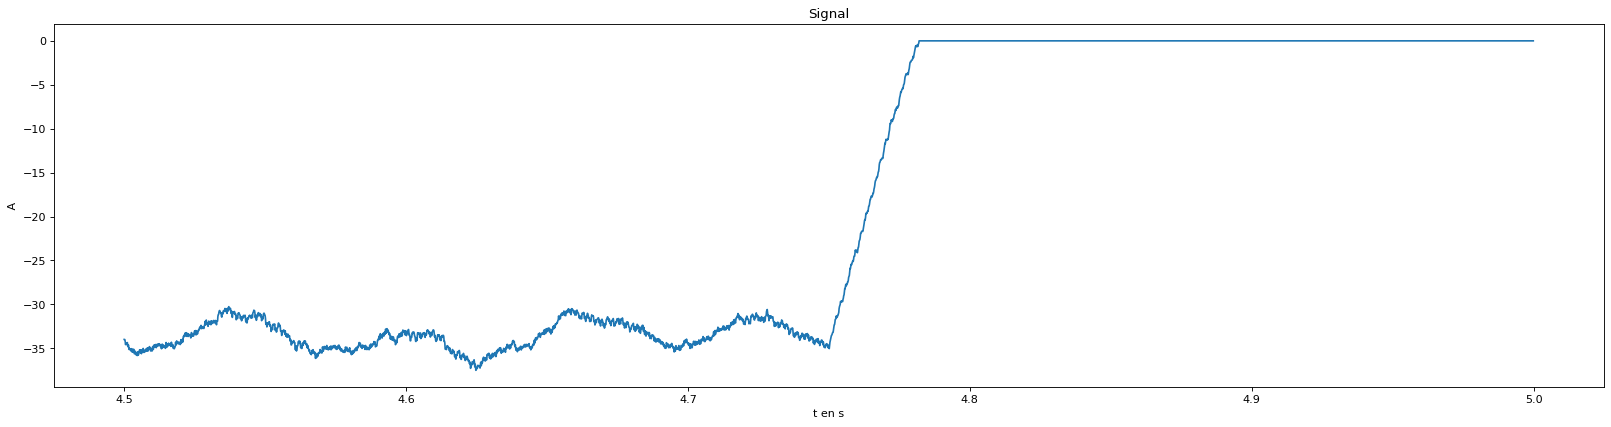

In [0]:
plt.figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t_portion+4.5, s)
plt.title("Signal")
plt.xlabel("t en s")
plt.ylabel(" A ")
plt.show()

Ci Dessus nous avons une représentation du signal filtré dans le domaine temporel.

# Question 3



Pour cette question nous démontrons qu'il est possible de créer une porteuse dont la fréquence s'approche de $F = 1209\texttt{Hz}$ à partir d'un additionneur 16 bits.

Pour ce faire nous allons ajouter une valeur à chaque front de la clock à $8000 \texttt{Hz}$ afin de faire la valeur 1 en bit de poid fort.

In [0]:
clk = []
clk_quadra = []

Pour trouver notre delta, nous allons faire le calcul suivant : 

$$\Delta = \frac{1209 * 2^{16}}{8000} = 9904$$

In [0]:
delta = 9904

In [0]:
res = 0
cnt = 0

Ci dessous nous simulons notre additionneur 16 bits. Nous vérifions les MSB pour générer notre clock principale, et le bit à (MSB - 1) nous donne la quadrature du signal.

In [0]:
while cnt < L_portion:
  res = res + delta
  if res < 2**15:
    clk.append(-1)
    clk_quadra.append(1)
  elif (res <= 2**16):  # Vérification du bit de poid fort
    clk.append(1)
    clk_quadra.append(-1)
  else:
    clk.append(-1)
    clk_quadra.append(-1)
    res = 0
    
  cnt = cnt+1

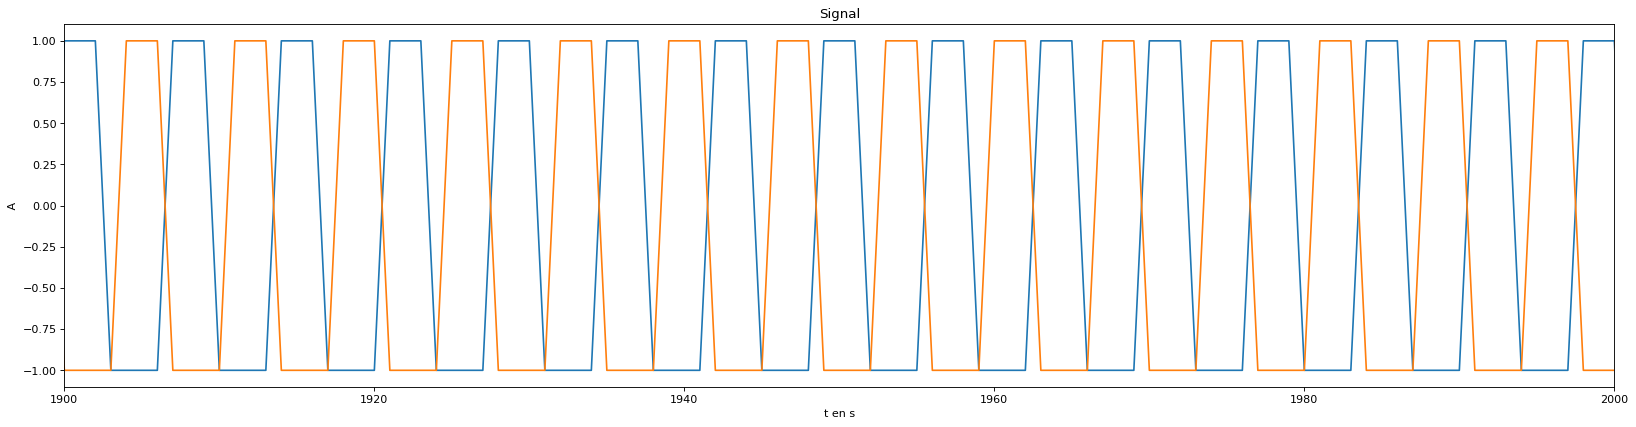

In [0]:
plt.figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(clk)
plt.plot(clk_quadra)
plt.title("Signal")
plt.xlabel("t en s")
plt.xlim(1900,2000)
plt.ylabel(" A ")
plt.show()

Ci dessus, en bleu nous avons la courbe à une fréquence proche de $1209\texttt{Hz}$. En orange nous avons le signal en quadrature.

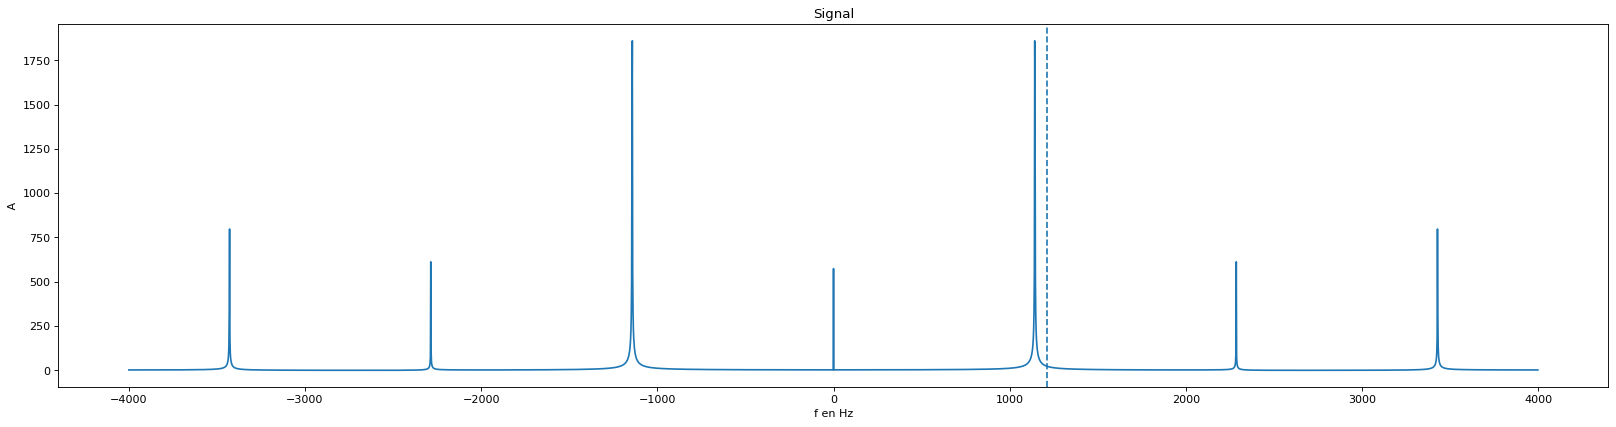

In [0]:
plt.figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(f_portion,fftshift(abs(fft(clk))))
plt.title("Signal")
plt.xlabel("f en Hz")
plt.ylabel(" A ")
plt.axvline(1209, linestyle='--')
plt.show()

Ci dessus nous avons tracé la FFT de notre signal afin de vérifier si notre fréquence s'approche bien des 1209Hz demandé. Nous voyons que nous ne sommes pas excatements sur la fréquence vouloue.

### Question 4

![Texte alternatif…](https://raw.githubusercontent.com/PierreFontaine/TNS/master/mult.jpg)

## Question 5